<a href="https://colab.research.google.com/github/hipster-x/azsii1/blob/main/pr4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Анализ защищенности систем искусственного интеллекта
# Практическое задание №4
# Атака DeepFool на модели ИИ
## Выполнил студент группы ББМО-02-23
## Макаров Михаил Максимович

In [1]:
!pip install art
!pip install adversarial-robustness-toolbox

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.6/71.6 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 608.6/608.6 kB 16.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 18.7 MB/s eta 0:00:00


## Загрузка обученнной модели и данных MNIST

In [2]:
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical

(_, _), (test_images, test_labels) = mnist.load_data()

test_images = test_images / 255.0

test_labels = to_categorical(test_labels, num_classes=10)

model = tf.keras.models.load_model('mmodel.h5')

test_loss, test_acc = model.evaluate(test_images, test_labels)
print(f'Test accuracy on clean images: {test_acc}')

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9738 - loss: 0.0893
Test accuracy on clean images: 0.9767000079154968


 ## Реализация атаки DeepFool с использованием Foolbox

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 34.3 MB/s eta 0:00:00


Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


tf.Tensor(7, shape=(), dtype=int64)


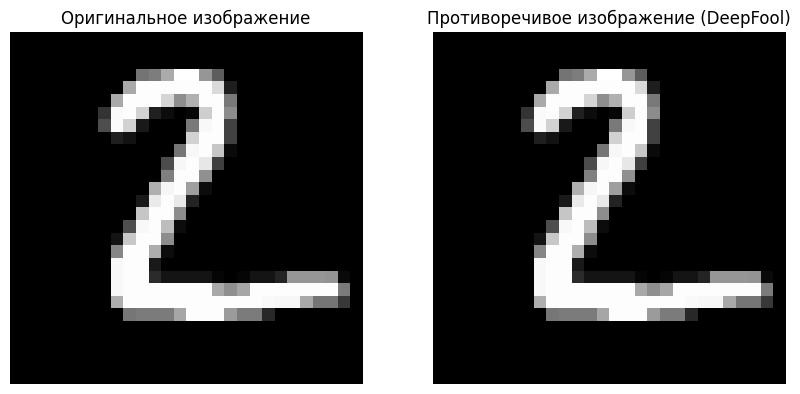

In [4]:
!pip install foolbox
import foolbox as fb
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf


# Инициализация Foolbox модели
fmodel = fb.TensorFlowModel(model, bounds=(-1, 1))

image = tf.convert_to_tensor(test_images[1], dtype=tf.float32)[None, ...]  # Добавляем размерность для батча
label = np.argmax(test_labels[0])  # Получаем индекс класса
label = tf.convert_to_tensor(label, dtype=tf.int64)  # Преобразуем в тензор

# Выполнение атаки
attack = fb.attacks.L2DeepFoolAttack(steps=10)
print(label)
advs, _, success = attack(fmodel, image, label[None], epsilons=0.01)  # Оборачиваем метку в тензор с размерностью (1,)

# Вывод результатов
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("Оригинальное изображение")
plt.imshow(image[0].numpy(), cmap="gray")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title("Противоречивое изображение (DeepFool)")
plt.imshow(advs[0].numpy(), cmap="gray")  # Предполагается, что advs имеет правильную форму
plt.axis('off')

plt.show()

## Оценка модели на противоречивых примерах

In [5]:
import tensorflow as tf
import numpy as np

# Количество случайных изображений
num_random_images = 100

# Выбираем случайные индексы из тестового набора
random_indices = np.random.choice(len(test_images), num_random_images, replace=False)

adversarial_images = []

# Обрабатываем только 100 случайных изображений
for i in random_indices:
    # Преобразуем изображение в тензор с правильным типом
    image = tf.convert_to_tensor(test_images[i], dtype=tf.float32)[None, ...]

    # Предполагаем, что метки уже в one-hot формате, если нет, используем np.argmax
    label = np.argmax(test_labels[i])
    label = tf.convert_to_tensor(label, dtype=tf.int64)  # Преобразуем метку в тензор

    # Генерация атакованного изображения с использованием метода __call__
    advs, _, success = attack(fmodel, image, label[None], epsilons=0.01)
    adversarial_images.append(advs)

# Объединяем все атакованные изображения
adversarial_images = tf.concat(adversarial_images, axis=0)

# Оценка модели на атакованных изображениях
adversarial_loss, adversarial_acc = model.evaluate(adversarial_images, test_labels[random_indices])
print(f'Accuracy on adversarial examples (DeepFool) для 100 рандомных изображений: {adversarial_acc}')


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.0000e+00 - loss: 137.2404 
Accuracy on adversarial examples (DeepFool) для 100 рандомных изображений: 0.0


## Реализация атаки DeepFool на первых 100 изображениях

DeepFool:   0%|          | 0/100 [00:00<?, ?it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
Точность на исходных изображениях: 99.00%
Точность на атакованных изображениях: 1.00%
Потери на исходных изображениях: 0.0317
Потери на атакованных изображениях: 61.3028


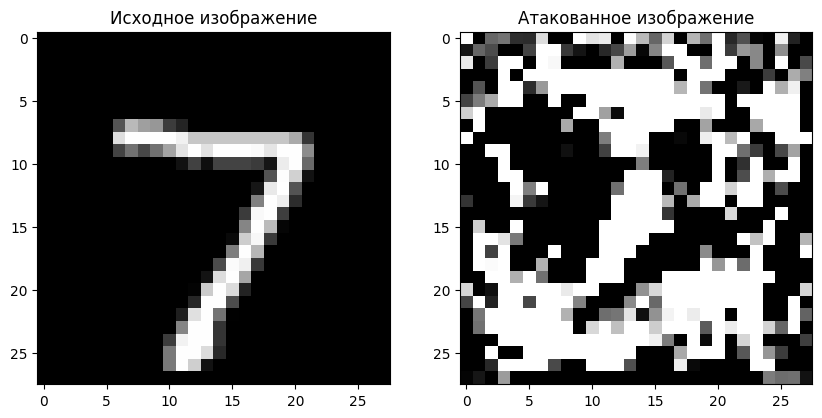

In [7]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.models import load_model
from tensorflow.keras.datasets import mnist
import matplotlib.pyplot as plt
from art.attacks.evasion import DeepFool
from art.estimators.classification import TensorFlowV2Classifier
from sklearn.metrics import accuracy_score
from tensorflow.keras.utils import to_categorical

# Загрузка модели
model = load_model('mmodel.h5')

# Загрузка и подготовка данных MNIST
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_test = x_test.astype(np.float32) / 255.0  # Нормализация
x_test = np.expand_dims(x_test, axis=-1)  # Добавление канала для изображений

# Преобразование меток в one-hot encoding
y_test_one_hot = to_categorical(y_test[:100], 10)

# Создание классификатора для ART
classifier = TensorFlowV2Classifier(model=model, nb_classes=10, input_shape=(28, 28, 1), clip_values=(0, 1))

# Применение атаки DeepFool
attack = DeepFool(classifier, max_iter=50)

# Получаем атакованные примеры
adv_images = attack.generate(x=x_test[:100])  # Берем первые 100 изображений для примера

# Предсказания модели на исходных и атакованных изображениях
original_predictions = np.argmax(model.predict(x_test[:100]), axis=1)
adv_predictions = np.argmax(model.predict(adv_images), axis=1)

# Вычисление точности
original_accuracy = accuracy_score(y_test[:100], original_predictions)
adv_accuracy = accuracy_score(y_test[:100], adv_predictions)

# Потери
original_loss = model.evaluate(x_test[:100], y_test_one_hot, verbose=0)
adv_loss = model.evaluate(adv_images, y_test_one_hot, verbose=0)

# Вывод результатов
print(f"Точность на исходных изображениях: {original_accuracy * 100:.2f}%")
print(f"Точность на атакованных изображениях: {adv_accuracy * 100:.2f}%")
print(f"Потери на исходных изображениях: {original_loss[0]:.4f}")
print(f"Потери на атакованных изображениях: {adv_loss[0]:.4f}")

# Визуализация исходного и атакованного изображения для первого примера
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

# Исходное изображение
ax[0].imshow(x_test[0].reshape(28, 28), cmap='gray')
ax[0].set_title("Исходное изображение")

# Атакованное изображение
ax[1].imshow(adv_images[0].reshape(28, 28), cmap='gray')
ax[1].set_title("Атакованное изображение")

plt.show()

## Вывод

Точность модели на атакованных примерах достигает 0%, что свидетельствует о значительном снижении её эффективности. Это может быть связано с высокой уязвимостью модели к небольшим, но тщательно рассчитанным изменениям в изображениях, которые специально разработаны для обмана модели. Даже незначительные искажения, такие как те, что применяются в атаке DeepFool, способны существенно нарушить работу модели, приводя к ошибочным предсказаниям.

Такое резкое падение точности указывает на недостаточную устойчивость модели к внешним воздействиям. В реальных условиях, где изображения могут подвергаться искажениям или преднамеренным манипуляциям, подобные уязвимости могут стать критическими. Например, в системах безопасности, медицинской диагностике или автономных транспортных средствах такие слабости могут быть использованы для манипуляции результатами распознавания, что приведет к серьезным последствиям.

Это подчеркивает важность разработки моделей, устойчивых к атакам, особенно в условиях, где возможны враждебные воздействия. Учет устойчивости к adversarial examples становится критически важным для обеспечения надежности и безопасности моделей в реальных приложениях.